# Lecture9: ResNetwork 

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

## Data processing 

In [2]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

num_classes = 10
num_features = 784
x_trainval = x_trainval.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
print(type(x_test))

x_trainval = x_trainval.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

y_trainval = y_trainval.astype("float32")
y_test = y_test.astype("float32")

indices = np.random.permutation(x_trainval.shape[0]) # return a permuted range('x_trainval.shape[0]') 
train_indices = indices[:-10000] # first 'len(indices) - 10000' for train
val_indices = indices[-10000:]   # last 10000 samples for validation
x_train = x_trainval[train_indices]
y_train = y_trainval[train_indices]
x_val = x_trainval[val_indices]
y_val = y_trainval[val_indices]

batch_size = 200
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(50000).batch(batch_size).prefetch(1)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.shuffle(10000).batch(batch_size).prefetch(1)
print(type(train_data))

<class 'numpy.ndarray'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [3]:
batch_x, batch_y = next(iter(test_data))  ### 이거 뭐지?

In [4]:
print(batch_y.shape) ### 이거뭐지

(200,)


## Model
### conv1 > maxpool > conv2 > maxpool > flatten > dense > out

In [5]:
class CNN(Model):
    # Set layers.
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=3, strides=(1,1),
                                   padding="same", activation=tf.nn.relu)
#                                    padding=[[0,0],[1,1],[1,1],[0,0]], activation=tf.nn.relu)
        self.maxpool1 = layers.MaxPool2D((2,2), strides=2)
        self.conv2 = layers.Conv2D(64, kernel_size=3, strides=(1,1),
                                   padding="same", activation=tf.nn.relu)
        self.maxpool2 = layers.MaxPool2D((2,2), strides=2)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128)
        self.out = layers.Dense(num_classes) ###마지막 softmax안한것 차이 말해주기 

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

### Trainig  : loss , optimizer , discription 

* BinaryCrossentropy => 2진 분류(0,1)  
  - 마지막에 activation(sigmoid)을 끼고 나오면 from_logits=False  
  - activation(sigmoid)이 없으면 from_logits=True  
  
* Categorical_crossentropy => 다중 분류(label 여러개)  
  - 마지막에 activation(softmax)을 끼고 나오면 from_logits=False  
  - activation(softmax)이 없으면 from_logits=True  
  
y_true = [[0,1,0],[0,0,1]]  => categorical_crossentropy(다중분류)  
y_true = [1,2] => sparse_categorical_crossentropy(다중분류)  

In [6]:
def cross_entropy_loss(x, y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x) # sparse -> one hot encoding 
    return tf.reduce_mean(loss)
#sparse_softmax_cross_entropy_with_logits / softmax_cross_entropy -> softmax로 activation 안했을 경우 logits선택
# Accuracy metric.

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64)) 
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
def Train_model(model, optimizer, epo, print_loss=True, plot_graph=True):
    step_l = []
    loss_l = []
    
    for epoch in range(0,epo):
        
        running_loss = 0.0
        for step, (batch_x, batch_y) in enumerate(train_data, 1):
            # Wrap computation inside a GradientTape for automatic differentiation.
            with tf.GradientTape() as g:
                pred = model(batch_x, is_training=True)
                loss = cross_entropy_loss(pred, batch_y)

            trainable_variables = model.trainable_variables
            gradients = g.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            
            running_loss += loss.numpy()   
            if plot_graph:
                if step % 10 == 0:
                    step_l.append(epoch*250 + step)
                    loss_l.append(running_loss / 10)
                    running_loss = 0.0
        if print_loss:
                print("epoch: ", epoch+1, ", loss: ", loss.numpy())
    
    if plot_graph:
        plt.plot(step_l, loss_l)
    return model

def accuracy_batch(model, test_data):
    acc = 0
    for step, (batch_x, batch_y) in enumerate(test_data, 1):
        pred = model(batch_x, is_training=False)
        acc += accuracy(pred, batch_y)
    acc = acc/step * 100.
    return acc

CNN Training
epoch:  1 , loss:  0.582525
epoch:  2 , loss:  0.3279493
epoch:  3 , loss:  0.30951098
epoch:  4 , loss:  0.23118624
epoch:  5 , loss:  0.2976687


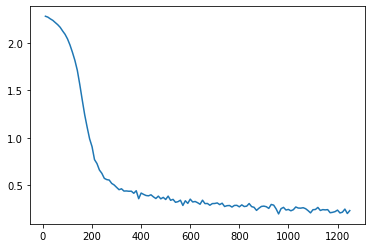

In [7]:
cnn = CNN()
optimizer = tf.optimizers.SGD(learning_rate= 0.001 , momentum =0.9)
print("CNN Training")
cnn = Train_model(cnn, optimizer, epo =5)

In [8]:
cnn_acc = accuracy_batch(cnn, test_data).numpy()
print("test accuracy =", cnn_acc)

test accuracy = 93.990005


 # ResNet

In [9]:
class BasicBlock(layers.Layer): # block내에서 돌아가는 연산에 대해 정의
    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = layers.Conv2D(filter_num, kernel_size=(3,3), strides=stride, padding="same", 
                                   kernel_initializer=tf.keras.initializers.he_normal()) # stride 때문에 차원이 줄어듬
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filter_num, kernel_size=(3,3), strides=1, padding="same", 
                                   kernel_initializer=tf.keras.initializers.he_normal())
        self.bn2 = layers.BatchNormalization()
        
        if stride != 1: # W에 대한 계산
            self.downsample = tf.keras.Sequential() # downsample = 사이즈를 줄이는 것
            self.downsample.add(layers.Conv2D(filter_num, kernel_size=(1,1), strides=stride)) # kernel_size =(1,1)이면 input과 size가 같고 stride에 의해서 절반으로 줄어듬
            self.downsample.add(layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, x, is_training=False):
        residual = self.downsample(x)   ## 이것이 x가 그대로 가게하는 역할 위의 lambda 까지! , calling 전에 했으니깐 그대로 들어온다

        x = self.conv1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training =is_training)
        x = tf.nn.relu(layers.add([residual, x])) # 마지막에 output값(W*x)에 x(=F(x))값을 더해줌

        return x

    
def make_basic_block_layer(filter_num, blocks, stride=1): 
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block
    
    
class ResNet18(Model):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding="same",
                                   kernel_initializer = tf.keras.initializers.he_normal())
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.pool1 = layers.MaxPool2D((3, 3), strides=2, padding="same")
        self.layer1 = make_basic_block_layer(filter_num=64, blocks=2)
        self.layer2 = make_basic_block_layer(filter_num=128, blocks=2, stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256, blocks=2, stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512, blocks=2, stride=2)
        self.avgpool1 = layers.GlobalAveragePooling2D()
        self.out = layers.Dense(10)
    
    def call(self, x, is_training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.pool1(x)
        x = self.layer1(x, training=is_training)
        x = self.layer2(x, training=is_training)
        x = self.layer3(x, training=is_training)
        x = self.layer4(x, training=is_training)
        x = self.avgpool1(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)

        return (x)

Train ResNet
epoch:  1 , loss:  0.31286252
epoch:  2 , loss:  0.18808754
epoch:  3 , loss:  0.13482694
epoch:  4 , loss:  0.11301455
epoch:  5 , loss:  0.12008433


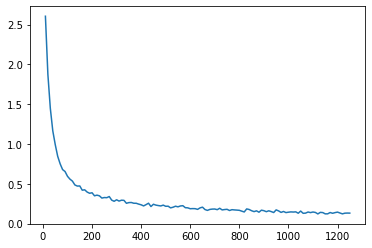

In [10]:
resnet18 = ResNet18()

optimizer = tf.optimizers.SGD(0.0001, momentum=0.9)
print("Train ResNet")
resnet18 = Train_model(resnet18, optimizer, 5)

In [11]:
res_acc = accuracy_batch(resnet18, test_data).numpy()
print("test accuracy =", res_acc)

test accuracy = 96.209984
